*Import Libraries*

In [ ]:
#Import Libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

import nltk
from nltk import word_tokenize         
from nltk.stem import WordNetLemmatizer

import tensorflow.keras as keras
import numpy as np
import os 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

*1. Cross-validation to evaluate the results using ROC_AUC for classification, and visualizing the coefficients*

In [ ]:
#Download data from aimodelshare

#!pip install aimodelshare
import aimodelshare as ai
x_train, x_test, y_train_labels, y_test_labels, example_data, lstm_model, lstm_model2 = ai.import_quickstart_data("clickbait")
print(x_train.head(10))
print(y_train_labels.head(10))


Data downloaded successfully.

Preparing downloaded files for use...

Success! Your Quick Start materials have been downloaded. 
You are now ready to run the tutorial.
0       MyBook Disk Drive Handles Lots of Easy Backups
1                       CIT Posts Eighth Loss in a Row
2    Candy Carson Singing The "National Anthem" Is ...
3    Why You Need To Stop What You're Doing And Dat...
4    27 Times Adele Proved She's Actually The Reale...
5    29 Times #BlackGirlMagic Was More Than Just A ...
6    Scientology ties at New Village Leadership Aca...
7               Judge Allows Asbestos Case to Continue
8              Cities Deal With a Surge in Shantytowns
9                15 Reasons December Is The Best Month
Name: headline, dtype: object
13620    not clickbait
15394    not clickbait
2796         clickbait
1673         clickbait
13020        clickbait
8961         clickbait
3152     not clickbait
6631     not clickbait
3892     not clickbait
14778        clickbait
Name: label, dtype: o

In [ ]:
# Helper function for plotting top positive and negative coefficients

def visualize_coefficients(coefficients, feature_names, n_top_features=25):
    """Visualize coefficients of a linear model.
    Parameters
    ----------
    coefficients : nd-array, shape (n_features,)
        Model coefficients.
    feature_names : list or nd-array of strings, shape (n_features,)
        Feature names for labeling the coefficients.
    n_top_features : int, default=25
        How many features to show. The function will show the largest (most
        positive) and smallest (most negative)  n_top_features coefficients,
        for a total of 2 * n_top_features coefficients.
    """
    coefficients = coefficients.squeeze()
    if coefficients.ndim > 1:
        # this is not a row or column vector
        raise ValueError("coeffients must be 1d array or column vector, got"
                         " shape {}".format(coefficients.shape))
    coefficients = coefficients.ravel()

    if len(coefficients) != len(feature_names):
        raise ValueError("Number of coefficients {} doesn't match number of"
                         "feature names {}.".format(len(coefficients),
                                                    len(feature_names)))
    # get coefficients with large absolute values
    coef = coefficients.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients,
                                          positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ['#ff2020' if c < 0 else '#0000aa'
              for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients],
            color=colors)
    feature_names = np.array(feature_names)
    plt.subplots_adjust(bottom=0.3)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features),
               feature_names[interesting_coefficients], rotation=60,
               ha="right")
    plt.ylabel("Coefficient magnitude")
    plt.xlabel("Feature")

MODEL 1: Logistic Regression using Default Tokenizer

In [ ]:
#Limiting data to 100 documents only
text_train1 = np.array(x_train[:])
text_train2 = np.array(x_test[:])
#Concatenate the text data
text_train = np.concatenate((text_train1, text_train2 ), axis=0)

#instantiate and fit/transform on count vectorizer
vect = CountVectorizer().fit(text_train)
x = vect.transform(text_train) #can also use fit_transform to omit this previous step

In [ ]:
#Define the X data
X = x
#Define the Y data
y1 = np.array(y_train_labels[:]) 
y2 = np.array(y_test_labels[:])
#concatenate the y data
y= np.append(y1, y2)

In [ ]:
#Test and train split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=11)

In [ ]:
#Get CV Score for Logistic Regression
scores = cross_val_score(LogisticRegression(), x_train, y_train, cv=5, scoring = 'roc_auc')
print("Mean cross-validation accuracy for model 1: {:.5f}".format(np.mean(scores)))

Mean cross-validation accuracy for model 1: 0.99577


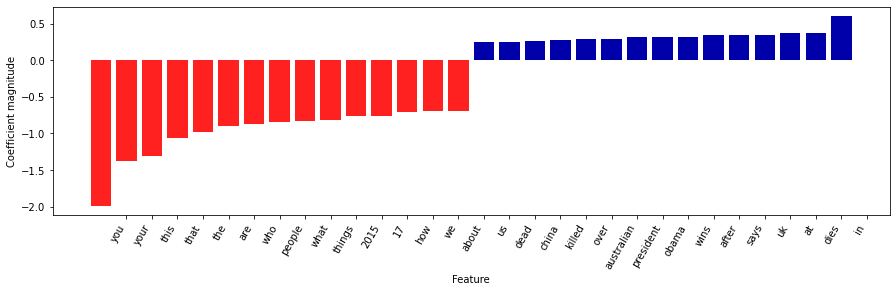

In [ ]:
#Visualization #1
coefs = LogisticRegression(C=0.01).fit(x_train,y_train).coef_
feature_names = vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=15)

MODEL 2: Logistic Regression using Bi-gram Vectorization

In [ ]:

#i. Define count vectorizer and insert tokenizer of choice
vect = CountVectorizer(ngram_range=(2, 2)).fit(text_train) #(2, 2) for Bi-gram, (1,2) for unigram and bigram, (1,3) for unigram, bigram, trigram
x = vect.transform(text_train)

#ii. redefine the training and test set data
X = x #Define the X data
y1 = np.array(y_train_labels[:]) #Define the Y data
y2 = np.array(y_test_labels[:])
#concatenate the y data
y= np.append(y1, y2)


#iii. train test split
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=11)


#iv. Build logistic regression model, get mean CV score
scores = cross_val_score(LogisticRegression(), x_train, y_train, cv=5, scoring = 'roc_auc') #Get CV Score for Logistic Regression
print("Mean cross-validation accuracy for model 2: {:.5f}".format(np.mean(scores)))

Mean cross-validation accuracy for model 2: 0.98541


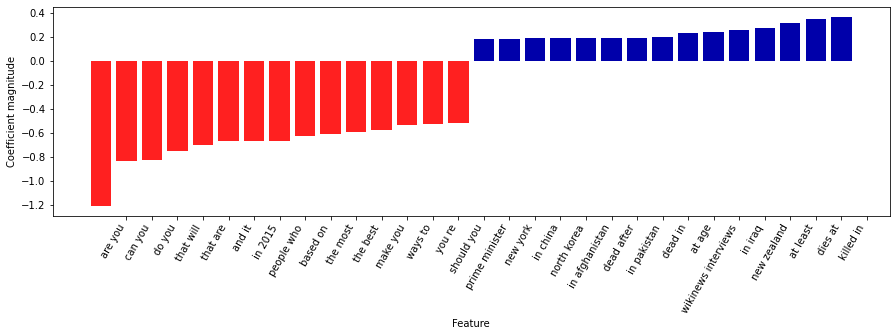

In [ ]:
#Visualization #2
coefs = LogisticRegression(C=0.01).fit(x_train,y_train).coef_
feature_names = vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=15)

MODEL 3: Logistic Regression using Lemmatization

In [ ]:

nltk.download('punkt')
nltk.download('wordnet')

#i. Set up custom tokenizer class. Using LemmaTokenizer but can also use Stemming
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

#iii. Define the count vectorizer w/the custom tokenizer, then fit_transform it
lemma_vect = CountVectorizer(tokenizer=LemmaTokenizer()).fit(text_train)
X_lemma = lemma_vect.transform(text_train)

#iv. Train test split before fitting on model
x_train, x_test, y_train, y_test = train_test_split(X_lemma, y, random_state=10)

#v. Build logistic regression model, get mean CV score
scores = cross_val_score(LogisticRegression(), x_train, y_train, cv=5, scoring = 'roc_auc')
print("Mean cross-validation accuracy for model 3: {:.5f}".format(np.mean(scores)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:489: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn("The parameter 'token_pattern' will not be used"


Mean cross-validation accuracy for model 3: 0.99671


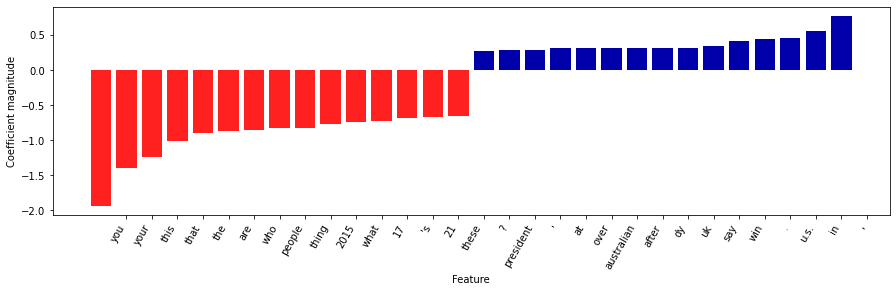

In [ ]:
#Visualization #3
coefs = LogisticRegression(C=0.01).fit(x_train,y_train).coef_
feature_names = lemma_vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=15)

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

#i. instantiate nltk's Porter stemmer
stemmer = nltk.stem.PorterStemmer()

class Stemmer(object):
    def __init__(self):
        self.wnl = stemmer
    def __call__(self, doc):
        return [self.wnl.stem(t) for t in word_tokenize(doc)]

#ii. Define the count vectorizer w/Stemmer, then fit_transform it
stemmer_vect = CountVectorizer(tokenizer=Stemmer())  
X_stemmer = stemmer_vect.fit_transform(text_train)

#iv. Train test split before fitting on model
x_train, x_test, y_train, y_test = train_test_split(X_stemmer, y, random_state=11)
#v. Build logistic regression model, get mean CV score and test score
scores = cross_val_score(LogisticRegression(), x_train, y_train, cv=5, scoring = 'roc_auc')
print("Mean cross-validation accuracy for model 4: {:.5f}".format(np.mean(scores)))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Mean cross-validation accuracy for model 4: 0.99697


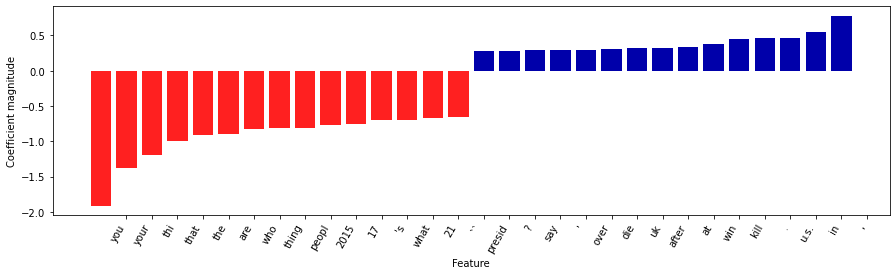

In [ ]:
#Visualization #4
coefs = LogisticRegression(C=0.01).fit(x_train,y_train).coef_
feature_names = stemmer_vect.get_feature_names()

visualize_coefficients(coefs, feature_names, n_top_features=15)

In [ ]:
log = LogisticRegression()
log.fit(x_train, y_train)
print("Stemmer test Score: {:.3f}".format(log.score(x_test, y_test)))

Stemmer test Score: 0.976


*Based on my results, the best model was model 4, which was the stemming approach. This conclusion was based on my comparisons between the mean cross validation scores of all 4 models. The model using the Stemmer tokenizer had the highest mean CV score at 0.9967, followed by the model using the Lemmatization tokenizer, then followed by the model with the default tokenizer, and finally the bi-gram model had the lowest CV score.
I then fit my final model on the testing data, and my test score came out with an accuracy score of 0.976.
Finally, the visualizations of the final model show that the model identifies that clickbait headlines tend to have words including things such as "You, your, that, are."*